## Hard Constraint

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import deepxde as dde
from utils.gs_solovev_sol import GS_Linear

A = -0.155
eps = 0.32
kappa = 1.7
delta = 0.33

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    eps = 0.32
    kappa = 1.7
    delta = 0.33
    N = num
    center, eps, kappa, delta = np.array([[0.0,0.0]]), eps, kappa, delta
    tau = np.linspace(0, 2 * np.pi, N)
    # Define boundary of ellipse
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau)]).T
    xvals = x_ellipse
    uvals = np.zeros(len(xvals)).reshape(len(xvals), 1)
    return xvals, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

center = np.array([0.0,0.0])
spatial_domain = dde.geometry.Ellipse(center, eps, kappa, delta) 
n_test = 100
npts = 1000
bc_dirichlet = dde.DirichletBC(spatial_domain, lambda x: 0, lambda _, on_boundary: on_boundary)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    bc_dirichlet,
    num_domain=npts,
    num_boundary=npts,
    num_test=n_test,
    train_distribution="LHS"
)

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term


/Users/yuxiangxue/NYU/Independent-study/deepxde_copy/deepxde/geometry/geometry_2d.py:81: RuntimeWarning: invalid value encountered in arcsin
  self.x_ellipse = np.asarray([1 + eps * np.cos(self.tau + np.arcsin(delta) * np.sin(self.tau)),


ValueError: operands could not be broadcast together with shapes (2,) (1001,) 

In [2]:
######################
#  Hard Constraints  #
######################

alpha = np.arcsin(delta)
### Notice we are making sure tf.acos() only receives arguments between [-1, 1] to avoid NaNs
def g_xy(x, y):
    return y - eps * kappa * tf.sin(tf.acos(tf.minimum(tf.maximum((x - 1) / eps, -1.0), 1.0)) - alpha * y / eps / kappa)
#     return y - eps * kappa * tf.sin(tf.acos((x - 1) / eps) - alpha * y / eps / kappa)

def g(x):
    x_coord = x[:, 0:1]
    y_coord = x[:, 1:2]
    return g_xy(x_coord, y_coord) * g_xy(x_coord, -y_coord)

def modify_output(x, y):
    return g(x) * y

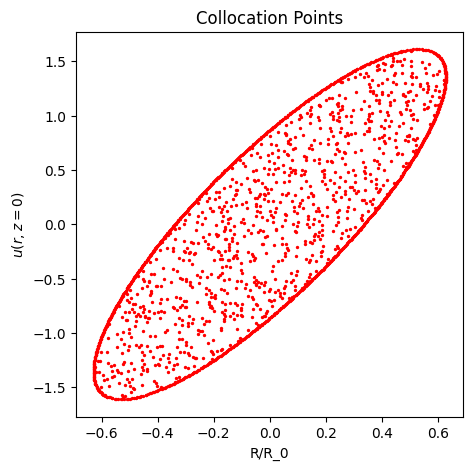

In [3]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5, 5))
ax.scatter(data.train_x[:, 0], data.train_x[:, 1], s=2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')
plt.show()

## Train Model

In [4]:
import time
DATE = time.strftime("%m%d%Y")
CONFIG = "ITER_Hard"
LR = 2e-3
DEPTH = 4
BREADTH = 40
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN(
    [2] + DEPTH * [BREADTH] + [1], 
    AF, "Glorot normal")

net.apply_output_transform(modify_output)

model = dde.Model(data, net)

decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,1], 
  )
  loss_history, train_state = model.train(epochs=100, display_every=1)
  dde.saveplot(
      loss_history,
      train_state, 
      issave=True, 
      isplot=True,
      output_dir=PATH
  )

# make mesh
nx = 100
ny = 100
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom
x, y = np.meshgrid(
    np.linspace(innerPoint, outerPoint, nx),
    np.linspace(lowPoint, highPoint, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T
output = model.predict(X)
GS = model.predict(X, operator=pde_solovev)
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)

Compiling model...
Building feed-forward neural network...
'build' took 0.071244 s

'compile' took 2.017383 s



I0000 00:00:1740672038.605041 10365197 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Training model...

Step      Train loss              Test loss               Test metric
0         [nan, 5.13e-09]         [nan, 5.13e-09]         []  
1         [nan, nan]              [nan, nan]              []  

Best model at step 0:
  train loss: inf
  test loss: inf
  test metric: 

'train' took 2.162584 s

Saving loss history to ./cefron/ITER_Hard/runs/network_sweep_02272025_depth04_breadth40_swish_lr0.002-varying-short_lw1-10_01_100Adam_BFGS/loss.dat ...
Saving training data to ./cefron/ITER_Hard/runs/network_sweep_02272025_depth04_breadth40_swish_lr0.002-varying-short_lw1-10_01_100Adam_BFGS/train.dat ...
Saving test data to ./cefron/ITER_Hard/runs/network_sweep_02272025_depth04_breadth40_swish_lr0.002-varying-short_lw1-10_01_100Adam_BFGS/test.dat ...


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

[[0.03862036 0.02523089 0.01493544 ... 1.03398694 1.70855296 2.60427015]
 [0.04620356 0.03060115 0.0184564  ... 0.98056892 1.62130931 2.47287398]
 [0.0541019  0.03621118 0.022149   ... 0.93040932 1.53939532 2.34950462]
 ...
 [0.05398844 0.03604246 0.02196125 ... 0.94069501 1.55480484 2.37130111]
 [0.04596424 0.0303268  0.01818527 ... 0.98977338 1.63566452 2.4937879 ]
 [0.03824354 0.02484436 0.01457904 ... 1.04130844 1.72085461 2.62311193]]
[[0.03862036 0.02523089 0.01493544 ... 1.03398694 1.70855296 2.60427015]
 [0.04620356 0.03060115 0.0184564  ... 0.98056892 1.62130931 2.47287398]
 [0.0541019  0.03621118 0.022149   ... 0.93040932 1.53939532 2.34950462]
 ...
 [0.05398844 0.03604246 0.02196125 ... 0.94069501 1.55480484 2.37130111]
 [0.04596424 0.0303268  0.01818527 ... 0.98977338 1.63566452 2.4937879 ]
 [0.03824354 0.02484436 0.01457904 ... 1.04130844 1.72085461 2.62311193]]


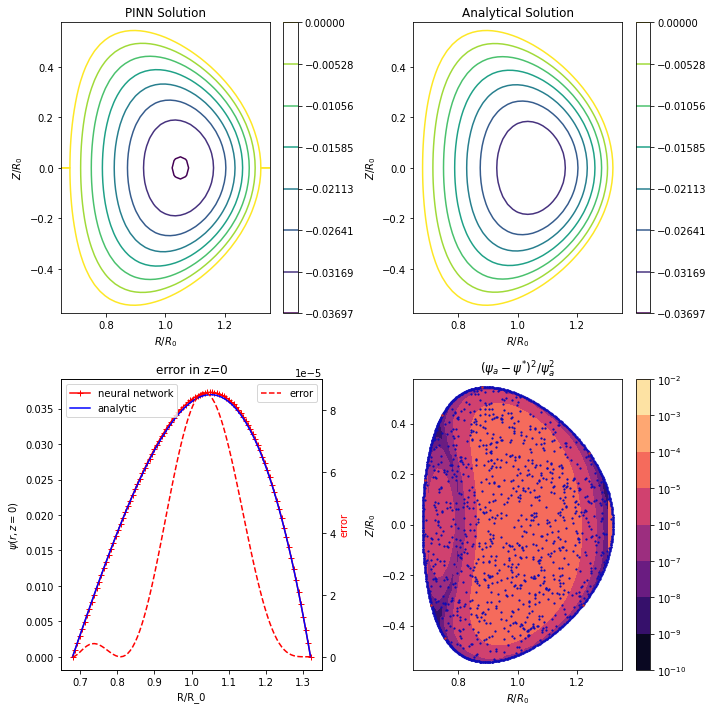

In [5]:
from utils.utils import *
ITER = GS_Linear(eps=0.32, kappa=1.7, delta=0.33)
ITER.get_BCs(A)
ITER.solve_coefficients()
X_test = spatial_domain.random_points(333)
plot_summary_figure(ITER, model, X_test, PATH)

#### After BFGS

Compiling model...
'compile' took 28.042895 s

Training model...

Step      Train loss              Test loss               Test metric
100       [5.44e-03, 5.53e-17]    [3.85e-04, 5.53e-17]    []  
110       [5.41e-03, 5.53e-17]    [5.41e-03, 5.53e-17]        
120       [5.38e-03, 5.53e-17]    [5.38e-03, 5.53e-17]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.005384
  Number of iterations: 5
  Number of functions evaluations: 29
129       [5.38e-03, 5.53e-17]    [3.67e-04, 5.53e-17]    []  

Best model at step 129:
  train loss: 5.38e-03
  test loss: 3.67e-04
  test metric: []

'train' took 21.461605 s

Saving loss history to ./cefron/ITER_Hard/runs/network_sweep_10272022_depth03_breadth40_swish_lr0.002-varying-short_lw1-10_01_100Adam_BFGS/loss.dat ...
Saving training data to ./cefron/ITER_Hard/runs/network_sweep_10272022_depth03_breadth40_swish_lr0.002-varying-short_lw1-10_01_100Adam_BFGS

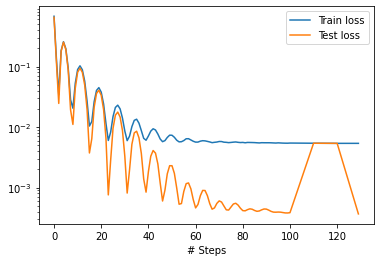

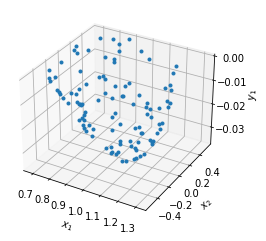

In [6]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1, 1]
)
loss_history, train_state = model.train(epochs=1000, display_every=10)
dde.saveplot(
    loss_history, 
    train_state, 
    issave=True, 
    isplot=True,
    output_dir=PATH
)


[[0.03791031 0.02467904 0.01452794 ... 1.04453193 1.72272667 2.62253495]
 [0.04548653 0.03003979 0.01803779 ... 0.98995863 1.63394032 2.48916313]
 [0.05338807 0.03564918 0.02172681 ... 0.93874627 1.55061653 2.36398229]
 ...
 [0.0531702  0.03539458 0.0214718  ... 0.94601467 1.56211321 2.380903  ]
 [0.04513872 0.02967701 0.01769839 ... 0.99564241 1.64373276 2.5043946 ]
 [0.03742308 0.02420366 0.0141042  ... 1.04776122 1.72973213 2.63478924]]
[[0.03791031 0.02467904 0.01452794 ... 1.04453193 1.72272667 2.62253495]
 [0.04548653 0.03003979 0.01803779 ... 0.98995863 1.63394032 2.48916313]
 [0.05338807 0.03564918 0.02172681 ... 0.93874627 1.55061653 2.36398229]
 ...
 [0.0531702  0.03539458 0.0214718  ... 0.94601467 1.56211321 2.380903  ]
 [0.04513872 0.02967701 0.01769839 ... 0.99564241 1.64373276 2.5043946 ]
 [0.03742308 0.02420366 0.0141042  ... 1.04776122 1.72973213 2.63478924]]


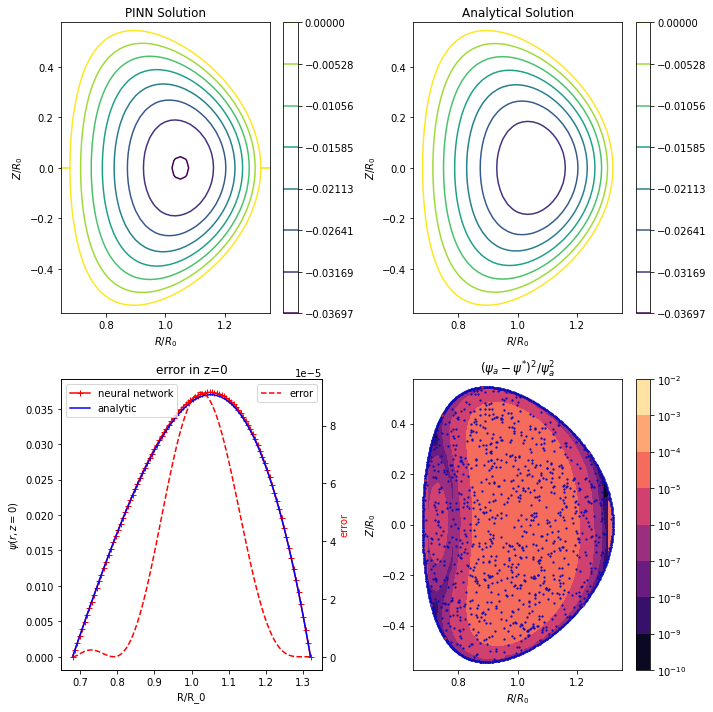

In [7]:
plot_summary_figure(ITER, model, X_test, PATH)

### Retrain WITHOUT hard boundary for direct comparison

Compiling model...
Building feed-forward neural network...


/Users/alankaptanoglu/deepxde_copy/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'build' took 0.273129 s

'compile' took 9.860938 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.15e+00, 3.48e-02]    [1.15e+00, 3.48e-02]    []  
1         [7.46e-01, 1.02e+01]    [7.27e-01, 1.02e+01]    []  
2         [1.01e+00, 1.87e-01]    [1.00e+00, 1.87e-01]    []  
3         [1.21e+00, 1.95e+00]    [1.21e+00, 1.95e+00]    []  
4         [1.16e+00, 1.08e+00]    [1.16e+00, 1.08e+00]    []  
5         [1.04e+00, 4.20e-02]    [1.04e+00, 4.20e-02]    []  
6         [9.25e-01, 8.25e-01]    [9.16e-01, 8.25e-01]    []  
7         [8.78e-01, 9.49e-01]    [8.67e-01, 9.49e-01]    []  
8         [8.81e-01, 2.65e-01]    [8.70e-01, 2.65e-01]    []  
9         [8.98e-01, 6.46e-02]    [8.89e-01, 6.46e-02]    []  
10        [9.09e-01, 3.48e-01]    [8.99e-01, 3.48e-01]    []  
11        [9.06e-01, 5.93e-01]    [8.97e-01, 5.93e-01]    []  
12        [8.93e-01, 5.51e-01]    [8.83e-01, 5.51e-01]    []  
13        [8.7

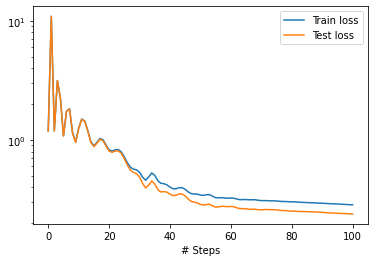

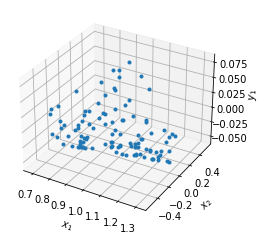

Accuracy
Mean residual: 0.3987355


In [8]:
DATE = "10272022"
CONFIG = "ITER_Hard"
LR = 2e-2
DEPTH = 3
BREADTH = 40
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN(
    [2] + DEPTH * [BREADTH] + [1], 
    AF, "Glorot normal")

model = dde.Model(data, net)

decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,100], 
  )
  loss_history, train_state = model.train(epochs=100, display_every=1)
  dde.saveplot(
      loss_history,
      train_state, 
      issave=True, 
      isplot=True,
      output_dir=PATH
  )

# make mesh
nx = 100
ny = 100
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom
x, y = np.meshgrid(
    np.linspace(innerPoint, outerPoint, nx),
    np.linspace(lowPoint, highPoint, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T
output = model.predict(X)
GS = model.predict(X, operator=pde_solovev)
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)

[[10.3494823  10.93589471 11.53482893 ...  5.74575274  4.59188061
   3.50742962]
 [ 7.67295946  8.18120615  8.70323443 ...  4.55322389  3.56537471
   2.64701719]
 [ 5.48697545  5.91952066  6.36682006 ...  3.52854551  2.69265869
   1.92653517]
 ...
 [ 4.65666948  4.74455481  4.82971153 ...  4.98904439  6.57938277
   8.48179787]
 [ 6.25834112  6.34350147  6.42458365 ...  4.91553728  6.55387226
   8.52143004]
 [ 8.16063229  8.23851863  8.31081489 ...  4.83365072  6.51998393
   8.5538092 ]]
[[10.3494823  10.93589471 11.53482893 ...  5.74575274  4.59188061
   3.50742962]
 [ 7.67295946  8.18120615  8.70323443 ...  4.55322389  3.56537471
   2.64701719]
 [ 5.48697545  5.91952066  6.36682006 ...  3.52854551  2.69265869
   1.92653517]
 ...
 [ 4.65666948  4.74455481  4.82971153 ...  4.98904439  6.57938277
   8.48179787]
 [ 6.25834112  6.34350147  6.42458365 ...  4.91553728  6.55387226
   8.52143004]
 [ 8.16063229  8.23851863  8.31081489 ...  4.83365072  6.51998393
   8.5538092 ]]


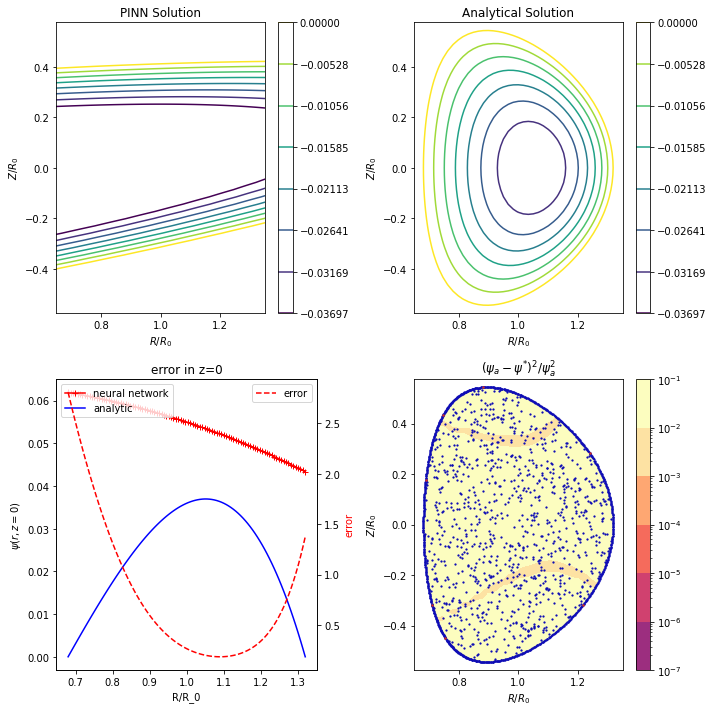

In [9]:
plot_summary_figure(ITER, model, X_test, PATH)

Compiling model...
'compile' took 11.520387 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.83e-01, 1.02e+00]    [1.37e-01, 1.02e+00]    []  
110       [4.81e-01, 2.52e-01]    [4.81e-01, 2.52e-01]        
120       [4.21e-01, 2.50e-01]    [4.21e-01, 2.50e-01]        
130       [4.55e-01, 1.72e-01]    [4.55e-01, 1.72e-01]        
140       [2.93e-01, 2.49e-01]    [2.93e-01, 2.49e-01]        
150       [1.43e-01, 1.99e-01]    [1.43e-01, 1.99e-01]        
160       [1.32e-01, 2.27e-02]    [1.32e-01, 2.27e-02]        
170       [5.29e-02, 5.48e-03]    [5.29e-02, 5.48e-03]        
180       [6.66e-03, 9.43e-03]    [6.66e-03, 9.43e-03]        
190       [5.77e-03, 3.32e-03]    [5.77e-03, 3.32e-03]        
200       [3.13e-03, 2.96e-03]    [3.13e-03, 2.96e-03]        
210       [2.82e-03, 2.59e-03]    [2.82e-03, 2.59e-03]        
220       [2.52e-03, 2.50e-03]    [2.52e-03, 2.50e-03]        
230       [2.19e-03, 2.14e-03]    [2.19e-03, 

1370      [1.20e-05, 2.29e-07]    [1.20e-05, 2.29e-07]        
1380      [1.19e-05, 1.58e-07]    [1.19e-05, 1.58e-07]        
1390      [1.14e-05, 3.58e-07]    [1.14e-05, 3.58e-07]        
1400      [1.14e-05, 3.48e-07]    [1.14e-05, 3.48e-07]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000012
  Number of iterations: 1054
  Number of functions evaluations: 1308
1408      [1.14e-05, 3.48e-07]    [1.89e-05, 3.48e-07]    []  

Best model at step 1408:
  train loss: 1.18e-05
  test loss: 1.92e-05
  test metric: []

'train' took 108.558744 s

Saving loss history to ./cefron/ITER_Hard/runs/network_sweep_10272022_depth03_breadth40_swish_lr0.02-varying-short_lw1-10_01_100Adam_BFGS/loss.dat ...
Saving training data to ./cefron/ITER_Hard/runs/network_sweep_10272022_depth03_breadth40_swish_lr0.02-varying-short_lw1-10_01_100Adam_BFGS/train.dat ...
Saving test data to ./cefron/ITER_Hard/runs/network_s

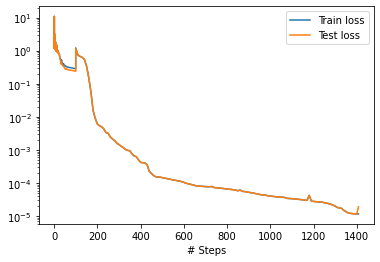

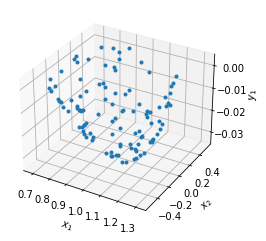

In [10]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1, 1000]
)
loss_history, train_state = model.train(epochs=1000, display_every=10)
dde.saveplot(
    loss_history, 
    train_state, 
    issave=True, 
    isplot=True,
    output_dir=PATH
)


[[2.39142352e-03 2.60370460e-03 2.79282537e-03 ... 4.72011647e-01
  5.32407492e-01 5.99092385e-01]
 [1.59186644e-03 1.73287602e-03 1.85743350e-03 ... 3.85162774e-01
  4.32855082e-01 4.85288865e-01]
 [1.03359404e-03 1.12600028e-03 1.20515385e-03 ... 3.08368039e-01
  3.45112347e-01 3.85414862e-01]
 ...
 [3.10743417e-04 4.81543327e-04 6.77614835e-04 ... 3.43155847e-01
  3.91647303e-01 4.45572103e-01]
 [5.92435125e-04 8.61434543e-04 1.16199324e-03 ... 4.08999918e-01
  4.68655668e-01 5.35140829e-01]
 [1.04033371e-03 1.44627311e-03 1.89143756e-03 ... 4.79845472e-01
  5.52026472e-01 6.32673503e-01]]
[[2.39142352e-03 2.60370460e-03 2.79282537e-03 ... 4.72011647e-01
  5.32407492e-01 5.99092385e-01]
 [1.59186644e-03 1.73287602e-03 1.85743350e-03 ... 3.85162774e-01
  4.32855082e-01 4.85288865e-01]
 [1.03359404e-03 1.12600028e-03 1.20515385e-03 ... 3.08368039e-01
  3.45112347e-01 3.85414862e-01]
 ...
 [3.10743417e-04 4.81543327e-04 6.77614835e-04 ... 3.43155847e-01
  3.91647303e-01 4.45572103e-01]

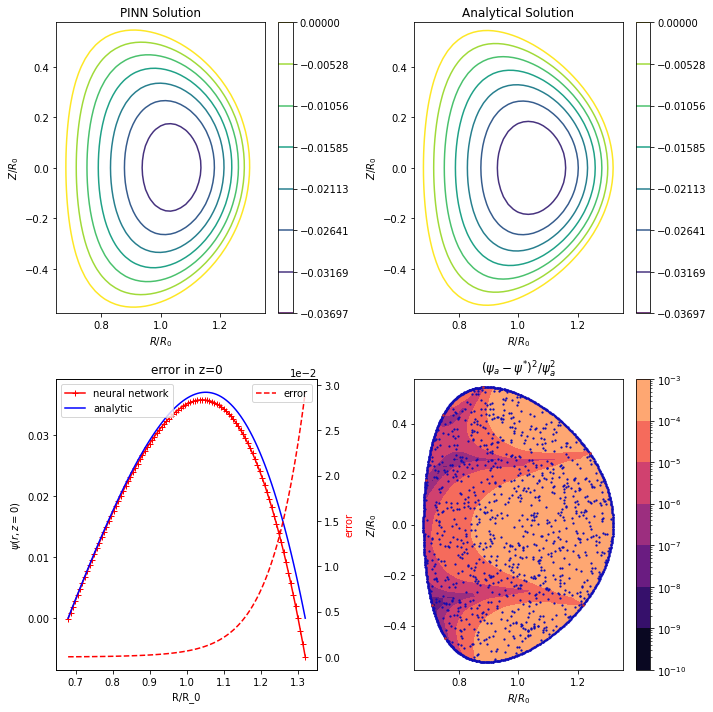

In [11]:
plot_summary_figure(ITER, model, X_test, PATH)